# LMT analysis script for Amy and Lucas' data; Day: Novel Object


@author: Amy Hassett (ft. Fabrice/ Elodie's code)

The purpose of this notebook is to act as the pipeline document for analysis of the LMT data, including any manipulations that must be performed before extracting the final data from the .sql database


**Steps:**
1. Set up the environment > import things into the code that will be used later
2. Set genotype/ group identity > change the genotype or group identity of the animals (can also be done directly in the SQL file)
3. Check experiment reliability
4. Rebuild all events > Rebuild the database to include all the events that the LMT can compute. (i.e. the ones that are not computed in real-time; Note: this includes "CorrectDetectionIdentity").
5. Check experiment reliability (post fixing up)

## Step 1: Performs the imports:

**Note that the window that pops up to get the sql file may be hidden by other windows.**

In [11]:
'''
Created on 15 fev. 2019

@author: Fab
'''
%matplotlib inline

import sys
sys.path.insert(1, "/mnt/Data1/LMT_Analysis/lmt-analysis-master/LMT")


import pandas as pd
import numpy as np

import sqlite3
from lmtanalysis.FileUtil import getFilesToProcess

from lmtanalysis.Animal import AnimalPool
from lmtanalysis.Measure import *
from lmtanalysis.Event import EventTimeLine, plotMultipleTimeLine

from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
import colorsys
from collections import Counter
import seaborn as sns

from tkinter.filedialog import askopenfilename
from lmtanalysis.Util import getMinTMaxTAndFileNameInput
from lmtanalysis.EventTimeLineCache import EventTimeLineCached
from lmtanalysis.FileUtil import getFilesToProcess


In [12]:
#ask the user for database to process
print( "Select file name in window")
files = getFilesToProcess()

Select file name in window


# Step 2: Set Genotype
This code lets you set the genotype of each animal in your database.

**Note that the text box will appear in the white area underneath this code!**

In [5]:
for file in files:
    
    print("---------------")
    print("Current file: " , file )
    
    connection = sqlite3.connect( file )
    
    pool = AnimalPool( )
    pool.loadAnimals( connection )
    
    for animal in pool.getAnimalList():
        print( "****")
        
        genotype = input( "Type new genotype for RFID "+ str(animal.RFID)+ " Current Genotype: " + str(animal.genotype) + " ([Enter] to keep existing one):")
        genotype = genotype.strip()
        if len(genotype) > 0:
            print("setting ", genotype , " to " , animal.RFID )
            animal.setGenotype( genotype )
        else:
            print( "keeping genotype", animal.genotype )
        
        name = input( "Type new name for RFID "+ str(animal.RFID)+ " Current Name: " + str(animal.name) + " ([Enter] to keep existing one):")
        name = name.strip()
        if len(name) > 0:
            print("setting ", name , " to " , animal.RFID )
            animal.setAnimalName(name)
        else:
            print( "keeping name", animal.name )
            
    print("Genotype saved in database.")

---------------
Current file:  /mnt/Data1/Arun/LMT/LMT_data/Not processed/1125-3-6-9_4-1-2023_novel_obj/1125-3-6-9_4-1-2023_novel_obj.sqlite
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:L7_TSC1_KO_test RFID:000005417089 Genotype:L7_TSC1_KO Strain:None Age:None Sex:None Setup:None
Animal Id:3 Name:L7_TSC1_KO_obj_1125_369 RFID:000005416947 Genotype:L7_TSC1_KO Strain:None Age:None Sex:None Setup:None
Animal Id:1 Name:L7_TSC1_KO_obj_1125_369 RFID:000005416973 Genotype:L7_TSC1_WT_obj_1125_369 Strain:None Age:None Sex:None Setup:None
****
Type new genotype for RFID 000005417089 Current Genotype: L7_TSC1_KO ([Enter] to keep existing one):
keeping genotype L7_TSC1_KO
Type new name for RFID 000005417089 Current Name: L7_TSC1_KO_test ([Enter] to keep existing one):L7_TSC1_KO_obj_1125_369
setting  L7_TSC1_KO_obj_1125_369  to  000005417089
****
Type new genotype for RFID 

# Step 3: Check experiment reliability (before processing)
this code gives feedback on how well the experiment does and saves the results as a txt file. In particular it describes how much of the detection was correctly detected

This code is repeated 5x below so that we can get the following data:
1. Missed detections (all of experiment)
2. Missed detections (hr1) 
3. Missed detections (hr2)
4. Missed detections (hr3)
5. Missed detections (hr1 + hr2; combined)

**Note: when naming the TXT file, ensure that it includes "_preprocessing" in the title**

In [ ]:
def reliabilitycheck(Files,text_file,startFrame=None,endFrame=None):
    for file in files:
        ## Txt file of entire experiment
        print( file )
        connection = sqlite3.connect( file )
        c = connection.cursor()
        text_file.write( file )
        text_file.write("\n")
        
        ##########################################################################
        '''Compute total recording duration'''
        print ("##############################################################")
        query = "SELECT MIN(TIMESTAMP) FROM FRAME";
        c.execute( query )
        rows = c.fetchall()
        for row in rows:
            realStartTime = datetime.datetime.fromtimestamp(row[0]/1000)
            realStartInSeconds = row[0]/1000
        
        #return realStartTime
        print( "Time of experiment start: {}".format(realStartTime) )
        text_file.write ( "Time of experiment start: {}\n".format(realStartTime) )
        
        query = "SELECT MAX(TIMESTAMP) FROM FRAME";
        c.execute( query )
        rows = c.fetchall()
        for row in rows:
            realEndTime = datetime.datetime.fromtimestamp(row[0]/1000)
            realEndInSeconds = row[0]/1000
        
        #return realEndTime
        print( "Time of experiment end: {}".format(realEndTime) )
        text_file.write( "Time of experiment end: {}\n".format(realEndTime) )
        #Total duration of experiment based on timestamp
        realDurationInSeconds = realEndInSeconds - realStartInSeconds + 1
        print( "Real duration of experiment: {} s ({} frames)".format( realDurationInSeconds, realDurationInSeconds*30 ) )
        text_file.write( "Real duration of experiment: {} s ({} frames)\n".format( realDurationInSeconds, realDurationInSeconds*30 ) )
        
        ##########################################################################
        '''Compute the total number of frames recorded'''
        #nbFramesRecorded = getNumberOfFrames(file)
        print ("##############################################################")
        query = "SELECT * FROM FRAME";
        c.execute( query )
        framesRecorded = c.fetchall()
        nbFramesRecorded = len(framesRecorded)
        print ( "Number of frames recorded:  {} frames ({} seconds or {} minutes or {} hours or {} days)".format(nbFramesRecorded, nbFramesRecorded/oneSecond, nbFramesRecorded/oneMinute, nbFramesRecorded/oneHour, nbFramesRecorded/oneDay))
        text_file.write( "Number of frames recorded:  {} frames ({} seconds or {} minutes or {} hours or {} days)\n".format(nbFramesRecorded, nbFramesRecorded/oneSecond, nbFramesRecorded/oneMinute, nbFramesRecorded/oneHour, nbFramesRecorded/oneDay) )
        
        query = "SELECT MIN(FRAMENUMBER) FROM FRAME";
        c.execute( query )
        minFrames = c.fetchall()
        if startFrame ==None:
            for minFrame in minFrames:
                startFrame = minFrame[0]
        
        query = "SELECT MAX(FRAMENUMBER) FROM FRAME";
        c.execute( query )
        maxFrames = c.fetchall()
        if endFrame==None:
            for maxFrame in maxFrames:
                endFrame = maxFrame[0]  
        
        durationExp = endFrame - startFrame +1
        print ("Experiment duration based on frames: {} frames".format(durationExp) ) 
        
        nbOmittedFrames = realDurationInSeconds*oneSecond - nbFramesRecorded
        print ( "Number of frames omitted: {} ({} % of the total experiment duration)".format (nbOmittedFrames, 100*nbOmittedFrames/(realDurationInSeconds*oneSecond)) )
        text_file.write( "Number of frames omitted: {} ({} % of the total experiment duration)\n".format (nbOmittedFrames, 100*nbOmittedFrames/(realDurationInSeconds*oneSecond)) )
        text_file.write("\n")
        
        print ("##############################################################")
        ##########################################################################
        '''Number of animals detected and rate of detection'''
        pool = AnimalPool( )
        pool.loadAnimals( connection )
        pool.loadDetection( start = 216000, end = endFrame, lightLoad=True)
        print ("##############################################################")
        
        for animal in pool.animalDictionary.keys():
            
            nbOfDetections = pool.animalDictionary[animal].getNumberOfDetection(tmin = startFrame, tmax = endFrame)

            missedDetection = 1-nbOfDetections/nbFramesRecorded
            
            print ( "Animal {}: {} missed detections over {} frames recorded ({} %)".format( pool.animalDictionary[animal].RFID, nbFramesRecorded-nbOfDetections, nbFramesRecorded, missedDetection*100 ) )
            text_file.write( "Animal {}: {} missed detections over {} frames recorded ({} %)\n".format( pool.animalDictionary[animal].RFID, nbFramesRecorded-nbOfDetections, nbFramesRecorded, missedDetection*100 ) )
            '''Note: The score can be low, if the animals are often huddled in the nest and not identified individually.'''
        
        ##########################################################################
        '''Number of RFID match'''
        print ("##############################################################")
        
        for animal in pool.animalDictionary.keys():
            rfidMatchTimeLine = EventTimeLine( connection, "RFID MATCH", idA = animal )
            rfidMismatchTimeLine = EventTimeLine( connection, "RFID MISMATCH", idA = animal )
            nbOfRfidMatch = rfidMatchTimeLine.getNumberOfEvent(minFrame=216000, maxFrame=endFrame)
            nbOfRfidMismatch = rfidMismatchTimeLine.getNumberOfEvent(minFrame=216000, maxFrame=endFrame)
            print( "Number of RFID match for animal {}: {} (rate: {} events/min)".format( pool.animalDictionary[animal].RFID, nbOfRfidMatch, nbOfRfidMatch/(durationExp*30*60) ) )
            print( "Number of RFID mismatch for animal {}: {} (rate: {} events/min)".format( pool.animalDictionary[animal].RFID, nbOfRfidMismatch, nbOfRfidMismatch/(durationExp*30*60) ) )
            text_file.write( "Number of RFID match for animal {}: {} (rate: {} events/min)\n".format( pool.animalDictionary[animal].RFID, nbOfRfidMatch, nbOfRfidMatch/(durationExp*30*60) ) )
            text_file.write( "Number of RFID mismatch for animal {}: {} (rate: {} events/min)\n".format( pool.animalDictionary[animal].RFID, nbOfRfidMismatch, nbOfRfidMismatch/(durationExp*30*60) ) )
            
        print ("##############################################################")
        ##########################################################################
        '''Check events'''
        text_file.write( "\n" )
        text_file.write("Total number of each event type:\n")
        for event in behaviouralEvents:
            eventTimeLine = EventTimeLine( connection, event )
            nbOfEvents = eventTimeLine.getNumberOfEvent(minFrame=None, maxFrame=None)
            text_file.write("{}:\t {}\n".format(event, nbOfEvents))
        
        text_file.write( "\n" )    
        text_file.write( "##############################################################\n" )
        ##########################################################################
    text_file.write( "\n" )
    
    text_file.close()
    
    print("job done")

In [9]:
## Reliability checks


import sqlite3
import math
import time
import datetime
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
import os
from tkinter.filedialog import askopenfilename
from lmtanalysis.Util import getMinTMaxTAndFileNameInput, getFileNameInput,\
    getNumberOfFrames
from lmtanalysis.FileUtil import getFilesToProcess


startFramelist=[None,None,108000,2160000,None]
endFramelist=[None,108000,2160000,None,2160000]
labels=["all","H1","H2","H3","H12"]


if __name__ == '__main__':
    '''This script allows to have an overview of the quality of the tracking for the whole experiment.'''
    
    behaviouralEvents = ["Contact", "Oral-oral Contact", "Oral-genital Contact", "Side by side Contact", "Side by side Contact, opposite way", "Social approach", "Social escape", "Approach contact", "Approach rear", "Break contact", "Get away", "FollowZone Isolated", "Train2", "Group2", "Group3", "Group 3 break", "Group 3 make", "Group4", "Group 4 break", "Group 4 make", "Huddling", "Move isolated", "Move in contact", "Nest3", "Nest4", "Rearing", "Rear isolated", "Rear in contact", "Stop isolated", "WallJump", "NovObj Zone", "NovObj Stop", "NovObj Interact"]
    ## Change these according to the behavioural day
    for i in range(len(startFramelist)):
        message="checking reliability before processing of time "+labels[i]+"\nReccomended to end the name with _preprocessing_"+labels[i]
        print(message)
        text_file = getFileNameInput()
        reliabilitycheck(files,text_file)

File name : test_preprocessing.txt
/mnt/Data1/Arun/LMT/LMT_data/Not processed/1125-3-6-9_4-1-2023_novel_obj/1125-3-6-9_4-1-2023_novel_obj.sqlite
##############################################################
Time of experiment start: 2023-01-04 13:22:31.031000
Time of experiment end: 2023-01-04 16:23:29.576000
Real duration of experiment: 10859.545000076294 s (325786.3500022888 frames)
##############################################################
Number of frames recorded:  325711 frames (10857.033333333333 seconds or 180.95055555555555 minutes or 3.0158425925925925 hours or 0.12566010802469135 days)
Experiment duration based on frames: 325711 frames
Number of frames omitted: 75.35000228881836 (0.023128655417358337 % of the total experiment duration)
##############################################################
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:L7

AttributeError: 'AnimalPool' object has no attribute 'animalDictionnary'

# Step 4:Rebuild All Events
    This script builds/rebuilds all the events of Live Mouse Tracker
   
   **Note: you need to make sure that you are using the notebook (and corresponding codes) that are correct for the particular experimental day that are you analysing.**
   
   **Note: this code also includes "CorrectDetectionIdentity" enabled, which will remove Detections where all three mice are not visible in the frame.**
    
    
## Step 4.5(optional): Parameters:
    This will compute automatically events for your database, and adjust settings for you.
    
    If you remove the automatic settings, you can force parameters:
        Set minT and maxT to process the database.
        Set windowT to divide the computation load in segment of that duration. Default value is 1 day.
    


In [11]:
import sys
sys.path.insert(1, "../")
from lmtanalysis.Measure import *

# set this to false if you want to set manual parameters.
automaticSettings = True

# Manual parameters:

''' minT and maxT to process the analysis (expressed in frame) '''
minT = 0
maxT = 3*oneDay
''' time window to compute the events (in frame). '''
windowT = 1*oneDay
''' speed up process '''
USE_CACHE_LOAD_DETECTION_CACHE = True

### Run this section to compute your database
    You will be prompted to provide a database

In [13]:
''' Created on 26 march 2019 @author: Fab '''

import sys
sys.path.insert(1, "../")
import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from lmtanalysis import BuildEventTrain3, BuildEventTrain4, BuildEventTrain2, BuildEventFollowZone, BuildEventRear5, BuildEventFloorSniffing,\
    BuildEventSocialApproach, BuildEventSocialEscape, BuildEventApproachContact,BuildEventOralOralContact,\
    BuildEventApproachRear, BuildEventGroup2, BuildEventGroup3, BuildEventGroup4, BuildEventOralGenitalContact, \
    BuildEventStop, BuildEventHuddling, BuildEventNovObj_Interaction, \
    BuildEventMove, BuildEventGroup3MakeBreak, BuildEventGroup4MakeBreak,\
    BuildEventSideBySide, BuildEventSideBySideOpposite, BuildEventDetection,\
    BuildDataBaseIndex, BuildEventWallJump, BuildEventSAP,\
    BuildEventOralSideSequence, CheckWrongAnimal,\
    CorrectDetectionIntegrity, BuildEventNest4, BuildEventNest3, BuildEventGetAway
    
from psutil import virtual_memory

from tkinter.filedialog import askopenfilename
from lmtanalysis.TaskLogger import TaskLogger
import sys
import traceback
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.EventTimeLineCache import flushEventTimeLineCache,\
    disableEventTimeLineCache


from lmtanalysis.EventTimeLineCache import EventTimeLineCached

def getNumberOfFrames(file):
    
    connection = sqlite3.connect( file )
    c = connection.cursor() 
    query = "SELECT MAX(FRAMENUMBER) FROM FRAME";
    c.execute( query )
    result = c.fetchall()
    numberOfFrames = int( result[0][0] )
    connection.close()
    
    return numberOfFrames

class FileProcessException(Exception):
    pass

eventClassList = [                  
                  BuildEventOralOralContact,
                  BuildEventOralGenitalContact,
                  BuildEventSideBySide,
                  BuildEventSideBySideOpposite,
                  BuildEventTrain2,                  
                  BuildEventTrain3,
                  BuildEventTrain4,
                  BuildEventMove,
                  BuildEventFollowZone,
                  BuildEventRear5,
                  BuildEventSocialApproach,
                  BuildEventGetAway,
                  BuildEventSocialEscape,
                  BuildEventApproachRear,
                  BuildEventGroup2,
                  BuildEventGroup3,
                  BuildEventGroup4,
                  BuildEventGroup3MakeBreak,
                  BuildEventGroup4MakeBreak,
                  BuildEventStop,
                  BuildEventHuddling,
                  BuildEventNovObj_Interaction,
                  BuildEventApproachContact,
                  BuildEventWallJump,
                  BuildEventSAP,
                  BuildEventOralSideSequence,
                  BuildEventNest3,
                  BuildEventNest4
                   ]
def flushEvents( connection ):
    
    print("Flushing events...")

    for ev in eventClassList:
        
        chrono = Chronometer( "Flushing event " + str(ev) )
        ev.flush( connection );      
        chrono.printTimeInS()
    

def processTimeWindow( connection, currentMinT , currentMaxT ):
    
    CheckWrongAnimal.check( connection, tmin=currentMinT, tmax=currentMaxT )
    
    # Warning: enabling this process (CorrectDetectionIntegrity) will alter the database permanently
    CorrectDetectionIntegrity.correct( connection, tmin=0, tmax=maxT )
                            
    BuildEventDetection.reBuildEvent( connection, file, tmin=currentMinT, tmax=currentMaxT )

    animalPool = None
    
    flushEventTimeLineCache()
    
    if ( USE_CACHE_LOAD_DETECTION_CACHE ):
        print("Caching load of animal detection...")
        animalPool = AnimalPool( )
        animalPool.loadAnimals( connection )
        animalPool.loadDetection( start = currentMinT, end = currentMaxT )
        print("Caching load of animal detection done.")

    for ev in eventClassList:
        
        chrono = Chronometer( str( ev ) )
        ev.reBuildEvent( connection, file, tmin=currentMinT, tmax=currentMaxT, pool = animalPool )        
        chrono.printTimeInS()

def process( file ):

    print(file)
    
    if automaticSettings:
        print("Automatic settings.")
        windowT = 1*oneDay
        minT = 0
        maxT = getNumberOfFrames( file )
        print ( "Auto max set to" , maxT , "frames")
        
    
    chronoFullFile = Chronometer("File " + file )
    
    connection = sqlite3.connect( file )
    
    # update missing fields
    try:
        connection = sqlite3.connect( file )    
        c = connection.cursor()            
        query = "ALTER TABLE EVENT ADD METADATA TEXT";
        c.execute( query )    
        connection.commit()
        c.close()
        connection.close()
    except:
        print( "METADATA field already exists" , file )
        
    #build index
    
    BuildDataBaseIndex.buildDataBaseIndex( connection, force=False )
        
    '''
    # build sensor data    
    animalPool = AnimalPool( )
    animalPool.loadAnimals( connection )
    animalPool.buildSensorData(file)
    '''
    
    currentT = minT

    try:

        flushEvents( connection )
        
        while currentT < maxT:
                        
            currentMinT = currentT
            currentMaxT = currentT+ windowT
            if ( currentMaxT > maxT ):
                currentMaxT = maxT
                
            chronoTimeWindowFile = Chronometer("File "+ file+ " currentMinT: "+ str(currentMinT)+ " currentMaxT: " + str(currentMaxT) );
            processTimeWindow( connection, currentMinT, currentMaxT )    
            chronoTimeWindowFile.printTimeInS()
            
            currentT += windowT

                        

        print("Full file process time: ")
        chronoFullFile.printTimeInS()
        
        TEST_WINDOWING_COMPUTATION = False
        
        if ( TEST_WINDOWING_COMPUTATION ):
                
            print("*************")
            print("************* TEST START SECTION")
            print("************* Test if results are the same with or without the windowing.")
            
            # display and record to a file all events found, checking with rolling idA from None to 4. Save nbEvent and total len
            
            eventTimeLineList = []
            
            eventList = getAllEvents( connection )
            file = open("outEvent"+str(windowT)+".txt","w")  
            file.write( "Event name\nnb event\ntotal duration" )
            
            for eventName in eventList:
                for idAnimalA in range( 0,5 ):                
                        idA = idAnimalA 
                        if idA == 0:
                            idA = None
                        timeLine = EventTimeLineCached( connection, file, eventName, idA,  minFrame=minT, maxFrame=maxT )
                        eventTimeLineList.append( timeLine )
                        file.write( timeLine.eventNameWithId+"\t"+str(len(timeLine.eventList))+"\t"+str(timeLine.getTotalLength())+"\n" )            
            
            file.close() 
    
            #plotMultipleTimeLine( eventTimeLineList )
            
            print("************* END TEST")
        
        
    except:
        
        exc_type, exc_value, exc_traceback = sys.exc_info()
        lines = traceback.format_exception(exc_type, exc_value, exc_traceback)
        error = ''.join('!! ' + line for line in lines)
        
        t = TaskLogger( connection )
        t.addLog( error )
        
        print( error, file=sys.stderr ) 
        
        raise FileProcessException()
            
def getAllEvents( connection ):
    
    query = "select name from event group by name order by name"
    c = connection.cursor()     
    c.execute( query )    
    all_rows = c.fetchall()        
    header = [ "Name" ]
    data =[]    
    for row in all_rows:
        data.append( row[0] )
    return data        

print("Code launched.")

mem = virtual_memory()
availableMemoryGB = mem.total / 1000000000
print( "Total memory on computer: (GB)", availableMemoryGB ) 

if availableMemoryGB < 10:
    print( "Not enough memory to use cache load of events.")
    disableEventTimeLineCache()

print("A window is popping (maybe hidden) asking for files to process...")
files = getFilesToProcess()

chronoFullBatch = Chronometer("Full batch" )    

if ( files != None ):

    for file in files:
        try:
            print ( "Processing file" , file )
            process( file )
        except FileProcessException:
            print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )

        flushEventTimeLineCache()

chronoFullBatch.printTimeInS()
print( "*** ALL JOBS DONE ***")

Code launched.
Total memory on computer: (GB) 34.276663296
A window is popping (maybe hidden) asking for files to process...
Processing file C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite
C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite
Automatic settings.
Auto max set to 343027 frames
METADATA field already exists C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite
Creating lmtanalysis indexes...
CREATE INDEX `animalIndex` ON `ANIMAL` (`ID` );
index animalIndex already exists
CREATE INDEX `detectionIndex` ON `DETECTION` (`ID` ASC,`FRAMENUMBER` ASC);
index detectionIndex already exists
CREATE INDEX `detetIdIndex` ON `DETECTION` (`ID` ASC);
index detetIdIndex already exists
CREATE INDEX `detframenumberIndex` ON `DETECTION` (`

Number of event deleted: 0 
[Chrono  Flushing event <module 'lmtanalysis.BuildEventStop' from '..\\lmtanalysis\\BuildEventStop.py'>  ]  0.06401586532592773  seconds
Deleting event Huddling (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="Huddling"
Number of event deleted: 0 
[Chrono  Flushing event <module 'lmtanalysis.BuildEventHuddling' from '..\\lmtanalysis\\BuildEventHuddling.py'>  ]  0.03200793266296387  seconds
Deleting event NovObj Zone (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="NovObj Zone"
Number of event deleted: 0 
Deleting event NovObj Stop (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="NovObj Stop"
Number of event deleted: 0 
Deleting event NovObj Interact (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="NovObj Interact"
Number of event deleted: 0 
[Chrono  Flushing event <module 'lmtanalysis.BuildEventNovObj_Interaction' from '..\\lmtanal

Animal Id:2 Name:M0020 RFID:000004809816 Genotype:Shank2_WT User1:None   104050  detections loaded in 2.616105079650879 seconds.
Caching load of animal detection done.
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:1 idB:2 idC:None idD:None loadEvent: False
Number of event:  1308
Mean length of event:  6.622324159021407
first event frame:  386
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 1308 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:1 idB:3 idC:None idD:None loadEvent: False
Number of event:  1560
Mean length of event:  4.916025641025641
first event frame:  1185
Keep previous entry.
Saving timeLine: Oral-oral Contact ( 1560 events )
Oral-oral Contact
Event Oral-oral Contact created. eventNameWithId = Oral-oral Contact idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  1308
Mean length of event:  6.622324159021407
first event frame:  386
Keep previous entry.


Number of event:  719
Mean length of event:  30.013908205841446
first event frame:  2459
Keep previous entry.
Saving timeLine: Side by side Contact, opposite way ( 719 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Side by side opposite','0','2020-10-06 19:15:56','0','343027' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventSideBySideOpposite' from '..\\lmtanalysis\\BuildEventSideBySideOpposite.py'>  ]  2.225257158279419  seconds
Oral-genital Contact  Id( 1 , 2 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 762  records loaded in  0.15703535079956055 S )
Caching eventTimeLine
Oral-genital Contact  Id( 1 , 3 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 662  records loaded in  0.1560356616973877 S )
Caching eventTimeLine
Oral-genital Contact  Id( 2 , 1 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 928  records loaded in  0.15203380584716797 S )
Caching eventTimeLine
Oral-genital Contact  Id( 2 , 3 , None , None ) 

Event Move isolated created. eventNameWithId = Move isolated idA:2 idB:None idC:None idD:None loadEvent: False
Number of event:  2008
Mean length of event:  7.168326693227091
first event frame:  2
Keep previous entry.
Saving timeLine: Move isolated ( 2008 events )
Event Move in contact created. eventNameWithId = Move in contact idA:2 idB:None idC:None idD:None loadEvent: False
Number of event:  1411
Mean length of event:  3.8710134656272146
first event frame:  347
Keep previous entry.
Saving timeLine: Move in contact ( 1411 events )
Event Move created. eventNameWithId = Move idA:3 idB:None idC:None idD:None loadEvent: False
Number of event:  2854
Mean length of event:  7.86229852838122
first event frame:  2
Keep previous entry.
Saving timeLine: Move ( 2854 events )
Event Move isolated created. eventNameWithId = Move isolated idA:3 idB:None idC:None idD:None loadEvent: False
Number of event:  1813
Mean length of event:  8.801434087148372
first event frame:  2
Keep previous entry.
Saving

Approach  Id( 3 , 2 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 9630  records loaded in  0.23806357383728027 S )
Caching eventTimeLine
mean animal bodysize:  32.76589269277114
mean animal bodysize:  34.156488875941164
mean animal bodysize:  33.19845185469981
Social approach
Event Social approach created. eventNameWithId = Social approach idA:1 idB:2 idC:None idD:None loadEvent: False
Number of event:  3953
Mean length of event:  6.161649380217557
first event frame:  330
Keep previous entry.
Saving timeLine: Social approach ( 3953 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:1 idB:3 idC:None idD:None loadEvent: False
Number of event:  3860
Mean length of event:  6.466839378238342
first event frame:  53
Keep previous entry.
Saving timeLine: Social approach ( 3860 events )
Social approach
Event Social approach created. eventNameWithId = Social approach idA:2 idB:1 idC:None idD:None loadEvent: False
Number of event:  4069
Mean leng

Get away  Id( 3 , 1 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 2955  records loaded in  0.24905753135681152 S )
Caching eventTimeLine
Get away  Id( 3 , 2 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 2941  records loaded in  0.25205516815185547 S )
Caching eventTimeLine
mean animal bodysize:  32.76589269277114
mean animal bodysize:  34.156488875941164
mean animal bodysize:  33.19845185469981
Social escape
Event Social escape created. eventNameWithId = Social escape idA:1 idB:2 idC:None idD:None loadEvent: False
Number of event:  2184
Mean length of event:  3.240842490842491
first event frame:  328
Keep previous entry.
Saving timeLine: Social escape ( 2184 events )
Social escape
Event Social escape created. eventNameWithId = Social escape idA:1 idB:3 idC:None idD:None loadEvent: False
Number of event:  2186
Mean length of event:  3.293687099725526
first event frame:  55
Keep previous entry.
Saving timeLine: Social escape ( 2186 events )
Social escape
Event Social esca

Contact  Id( 1 , 4 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.24405670166015625 S )
Caching eventTimeLine
Contact  Id( 2 , 1 , None , None ) Loaded from cache ( 834  records. )
Contact  Id( 2 , 3 , None , None ) Loaded from cache ( 823  records. )
Contact  Id( 2 , 4 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2430558204650879 S )
Caching eventTimeLine
Contact  Id( 3 , 1 , None , None ) Loaded from cache ( 1251  records. )
Contact  Id( 3 , 2 , None , None ) Loaded from cache ( 823  records. )
Contact  Id( 3 , 4 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2500581741333008 S )
Caching eventTimeLine
Contact  Id( 4 , 1 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2450559139251709 S )
Caching eventTimeLine
Contact  Id( 4 , 2 , None , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.24805688858032227 S )
Caching eventTimeLine
Contact  Id( 

Number of event:  126
Mean length of event:  423.8968253968254
first event frame:  456
Keep previous entry.
Saving timeLine: Group3 ( 126 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:3 idB:1 idC:4 idD:None loadEvent: False
No event in timeLine
no event
Keep previous entry.
Saving timeLine: Group3 ( 0 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:3 idB:2 idC:1 idD:None loadEvent: False
Number of event:  126
Mean length of event:  423.8968253968254
first event frame:  456
Keep previous entry.
Saving timeLine: Group3 ( 126 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:3 idB:2 idC:4 idD:None loadEvent: False
No event in timeLine
no event
Keep previous entry.
Saving timeLine: Group3 ( 0 events )
Group3
Event Group3 created. eventNameWithId = Group3 idA:3 idB:4 idC:1 idD:None loadEvent: False
No event in timeLine
no event
Keep previous entry.
Saving timeLine: Group3 ( 0 events )
Group3
Event Group3 created. eventNameWithId = Gro

Group3  Id( 1 , 3 , 2 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 126  records loaded in  0.27806687355041504 S )
Caching eventTimeLine
Group3  Id( 1 , 3 , 4 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.25505900382995605 S )
Caching eventTimeLine
Group3  Id( 1 , 4 , 2 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2600574493408203 S )
Caching eventTimeLine
Group3  Id( 1 , 4 , 3 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2470569610595703 S )
Caching eventTimeLine
Group3  Id( 2 , 1 , 3 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 126  records loaded in  0.2840542793273926 S )
Caching eventTimeLine
Group3  Id( 2 , 1 , 4 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2470569610595703 S )
Caching eventTimeLine
Group3  Id( 2 , 3 , 1 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 126  records loaded in  0.27307629585266113 S )
Caching eventTimeLine
Group3  Id( 2 , 3 , 4 , None ) Min/maxF

Group4  Id( 4 , 1 , 2 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2540555000305176 S )
Caching eventTimeLine
Group4  Id( 4 , 1 , 3 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.24805736541748047 S )
Caching eventTimeLine
Group4  Id( 4 , 2 , 1 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.2500472068786621 S )
Caching eventTimeLine
Group4  Id( 4 , 2 , 3 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.25007104873657227 S )
Caching eventTimeLine
Group4  Id( 4 , 3 , 1 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.252044677734375 S )
Caching eventTimeLine
Group4  Id( 4 , 3 , 2 , None ) Min/maxFrame: ( 0 / 343027 ) Loaded ( 0  records loaded in  0.24807024002075195 S )
Caching eventTimeLine
no event
Keep previous entry.
Saving timeLine: Group 4 make ( 0 events )
no event
Keep previous entry.
Saving timeLine: Group 4 break ( 0 events )
no event
Keep previous entry.
Savin

current t 200000
Problem in Mask.getRoundness()
current t 210000
current t 220000
current t 230000
current t 240000
current t 250000
current t 260000
current t 270000
current t 280000
current t 290000
current t 300000
current t 310000
current t 320000
current t 330000
current t 340000
Number of event:  599
Mean length of event:  4.906510851419032
first event frame:  539
Keep previous entry.
Saving timeLine: Huddling ( 599 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event Huddling','0','2020-10-06 19:27:38','0','343027' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventHuddling' from '..\\lmtanalysis\\BuildEventHuddling.py'>  ]  649.1164443492889  seconds
Animal Id:3 Name:M0021 RFID:000004809810 Genotype:Shank2_KO User1:None
A is in the zone around the novel object source
NovObj Zone
Event NovObj Zone created. eventNameWithId = NovObj Zone idA:3 idB:None idC:None idD:None loadEvent: False
Event NovObj Stop created. eventNameWithId = NovObj 

Number of event:  458
Mean length of event:  7.425764192139738
first event frame:  436
Keep previous entry.
Saving timeLine: SAP ( 458 events )
Event SAP created. eventNameWithId = SAP idA:1 idB:None idC:None idD:None loadEvent: False
Number of event:  510
Mean length of event:  8.072549019607843
first event frame:  239
Keep previous entry.
Saving timeLine: SAP ( 510 events )
Event SAP created. eventNameWithId = SAP idA:2 idB:None idC:None idD:None loadEvent: False
Number of event:  573
Mean length of event:  8.06457242582897
first event frame:  30
Keep previous entry.
Saving timeLine: SAP ( 573 events )
INSERT INTO LOG( process,version,date,tmin,tmax) VALUES ( 'Build Event SAP','0','2020-10-06 19:27:49','0','343027' );
Rebuild event finished.
[Chrono  <module 'lmtanalysis.BuildEventSAP' from '..\\lmtanalysis\\BuildEventSAP.py'>  ]  1.384188175201416  seconds
Animal Id:3 Name:M0021 RFID:000004809810 Genotype:Shank2_KO User1:None
mean animal bodysize:  33.19844130256748
Oral-oral Contac

# Step 5: Check experiment reliability; post-correction
this code gives feedback on how well the experiment does and saves the results as a txt file. In particular it describes how much of the detection was correctly detected

**Note: when naming these TXT files, ensure that it includes "_postprocessing" in the title**

In [ ]:
## Reliability checks


import sqlite3
import math
import time
import datetime
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
import os
from tkinter.filedialog import askopenfilename
from lmtanalysis.Util import getMinTMaxTAndFileNameInput, getFileNameInput,\
    getNumberOfFrames
from lmtanalysis.FileUtil import getFilesToProcess


startFramelist=[None,None,108000,2160000,None]
endFramelist=[None,108000,2160000,None,2160000]
labels=["all","H1","H2","H3","H12"]


if __name__ == '__main__':
    '''This script allows to have an overview of the quality of the tracking for the whole experiment.'''
    
    behaviouralEvents = ["Contact", "Oral-oral Contact", "Oral-genital Contact", "Side by side Contact", "Side by side Contact, opposite way", "Social approach", "Social escape", "Approach contact", "Approach rear", "Break contact", "Get away", "FollowZone Isolated", "Train2", "Group2", "Group3", "Group 3 break", "Group 3 make", "Group4", "Group 4 break", "Group 4 make", "Huddling", "Move isolated", "Move in contact", "Nest3", "Nest4", "Rearing", "Rear isolated", "Rear in contact", "Stop isolated", "WallJump", "NovObj Zone", "NovObj Stop", "NovObj Interact"]
    ## Change these according to the behavioural day
    for i in range(len(startFramelist)):
        message="checking reliability after processing of time "+labels[i]+"\nReccomended to end the name with _preprocessing_"+labels[i]
        print(message)
        text_file = getFileNameInput()
        reliabilitycheck(files,text_file)

# Step 6: Show sensor data

- This script plots the sensor data and saves them it in pdf figures.
- Sensor supported : temperature, sound level, humidity, visible light, visible + infrared light.
    

In [ ]:
##Optional, rechoose files to process for the plot
files = getFilesToProcess()

Code launched.
Processing file C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite
--------------
Current file:  C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:3 Name:M0021 RFID:000004809810 Genotype:Shank2_KO User1:None
Animal Id:1 Name:M0022 RFID:000004809824 Genotype:Shank2_WT User1:None
Animal Id:2 Name:M0020 RFID:000004809816 Genotype:Shank2_WT User1:None
Build sensor data
plotting sensor data.  TEMPERATURE
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 0  records loaded in  0.0690152645111084 S )
Saving figure : C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/1

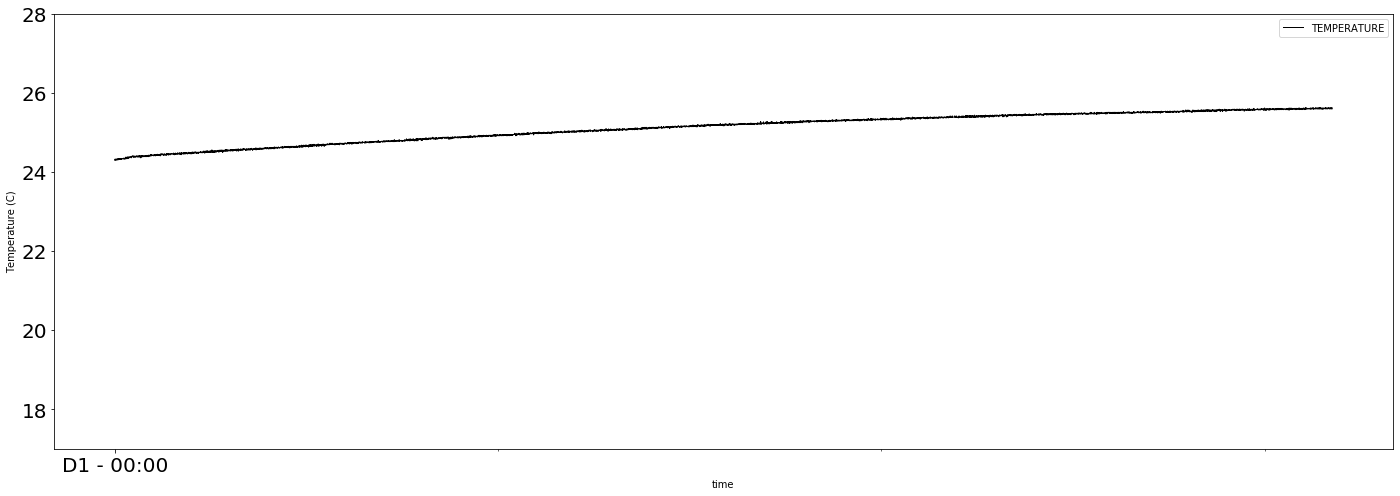

plotting sensor data.  SOUND
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 0  records loaded in  0.06801557540893555 S )
Saving figure : C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite_log_sound level.pdf
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range


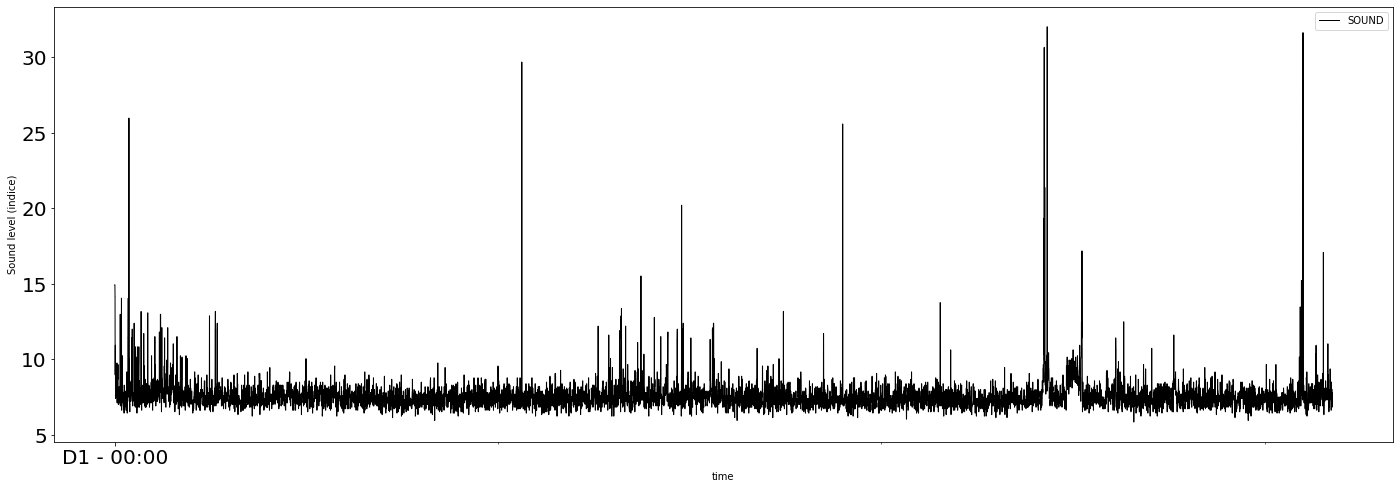

plotting sensor data.  HUMIDITY
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 0  records loaded in  0.06701469421386719 S )
Saving figure : C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite_log_humidity.pdf
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range


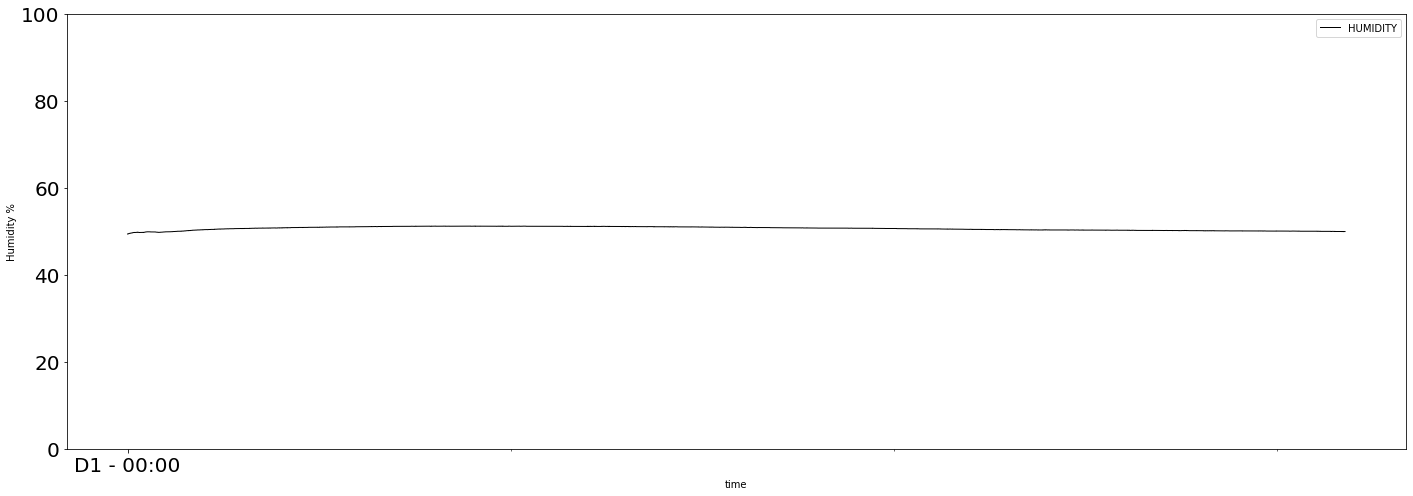

plotting sensor data.  LIGHTVISIBLE
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 0  records loaded in  0.06801557540893555 S )
Saving figure : C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite_log_light visible.pdf
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range


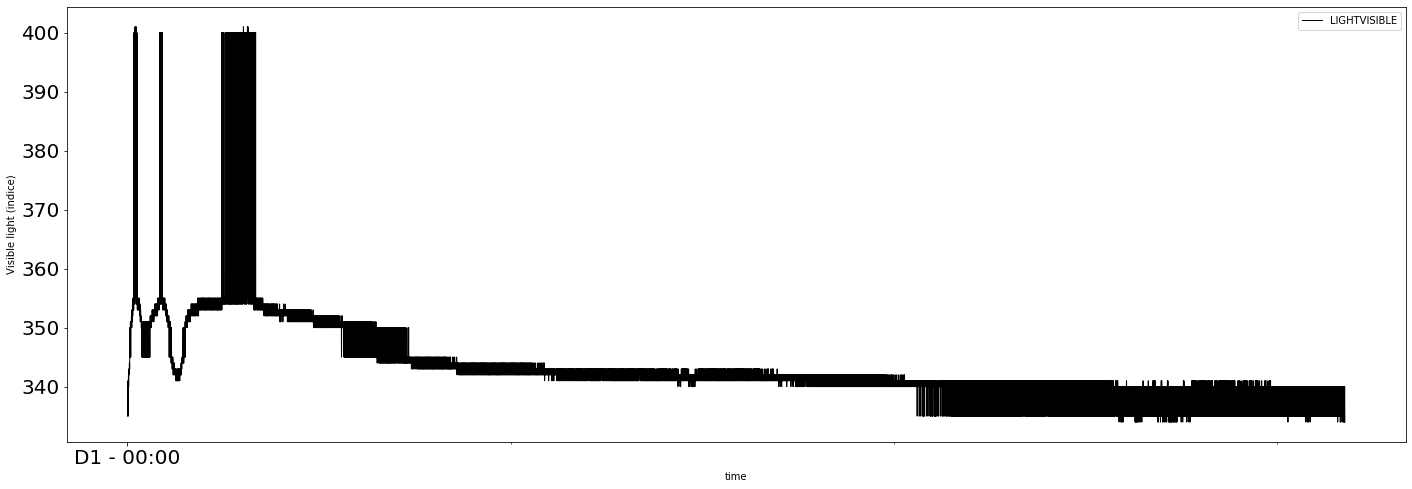

plotting sensor data.  LIGHTVISIBLEANDIR
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 0  records loaded in  0.06701493263244629 S )
Saving figure : C:/Users/amyhassett/Documents/LMT_Analysis/1-Behavioral_profiling_DATA/2. Python Processed Databases/15441-05-06-07_10-09-2020_Obj.sqlite_log_light visible and infra.pdf
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range
The entered framenumber is out of range


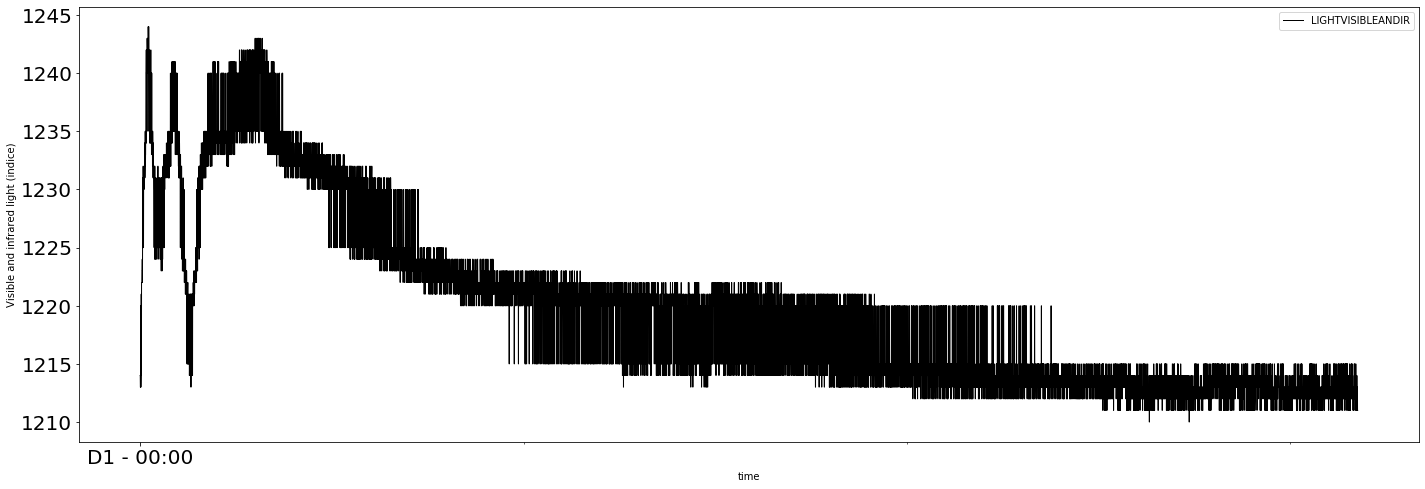

*** ALL JOBS DONE ***


In [19]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from tkinter.filedialog import askopenfilename
import sys
from lmtanalysis.FileUtil import getFilesToProcess

class FileProcessException(Exception):
    pass

def process( file ):
    
    connection = sqlite3.connect( file )     

    print( "--------------")
    print( "Current file: ", file )
    
    connection = sqlite3.connect( file )
    # build sensor data
    animalPool = AnimalPool( )
    animalPool.loadAnimals( connection )
    animalPool.buildSensorData( file, show = True  )
    
print("Code launched.")



if ( files != None ):

    for file in files:
        try:
            print ( "Processing file" , file )
            process( file )
        except FileProcessException:
            print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )

print( "*** ALL JOBS DONE ***")
        

# Step 7: Compute Bad Orientation Estimation 
Caveat: this only looks for events longer than 1 second

**Note: after running this step, you must rename the resulting TXT file with the numbers of the mice used, as it automatically saves this as "bad orientation", and this will be written over the next time this code is run with the next processed database**

In [ ]:
##Optional, rechoose files to process for the plot
files = getFilesToProcess()

In [10]:
animalDictionary'''
Created on 13 sept. 2017

@author: Fab
'''

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from lmtanalysis import BuildEventTrain3, BuildEventTrain4, BuildEventTrain2, BuildEventFollowZone, BuildEventRear5, BuildEventFloorSniffing,\
    BuildEventSocialApproach, BuildEventSocialEscape, BuildEventApproachContact,BuildEventOralOralContact,\
    BuildEventApproachRear, BuildEventGroup2, BuildEventGroup3, BuildEventGroup4, BuildEventOralGenitalContact, \
    BuildEventStop, BuildEventWaterPoint, \
    BuildEventMove, BuildEventGroup3MakeBreak, BuildEventGroup4MakeBreak,\
    BuildEventSideBySide, BuildEventSideBySideOpposite, BuildEventDetection,\
    BuildDataBaseIndex, BuildEventWallJump, BuildEventSAP,\
    BuildEventOralSideSequence, CheckWrongAnimal,\
    CorrectDetectionIntegrity
    

from lmtanalysis.TaskLogger import TaskLogger
import sys
import traceback
from lmtanalysis.FileUtil import getFilesToProcess

maxT = 3*oneDay
### Change this based on your thresholding, extreme speeds could indicate nonsensical tracking
SPEED_THRESHOLD_HIGH = NaN


class FileProcessException(Exception):
    pass

def getScalarProduct( a, b ):

    return a.x * b.x + a.y * b.y;

def isSameSign( a, b ):
    if ( a >= 0 and b >= 0 ):
         return True;
    if ( a < 0 and b < 0 ):
        return True;
    return False;


def process( file ):

    print(file)
    
    chronoFullFile = Chronometer("File " + file )
    
    connection = sqlite3.connect( file )        
        
                        
    try:

        animalPool = None
        
        print("Caching load of animal detection...")
        animalPool = AnimalPool( )
        animalPool.loadAnimals( connection )
        animalPool.loadDetection( start = 0, end = maxT )
        print("Caching load of animal detection done.")

        text_file = open ( "bad orientation.txt", "a")
  
        nb = {}
        totalLen = {}
  
        for animal in animalPool.getAnimalList():
            
            badOrientationTimeLine = EventTimeLine( None, "bad orientation auto" , animal.baseId , None , None , None , loadEvent=False )
            print ("Processing", animal )
            for t in range( 0, maxT ):
                
                orientation = animal.getOrientationVector( t )
                speedVector = animal.getSpeedVector( t )
                speed = animal.getSpeed( t )

                if ( orientation != None and speedVector != None and speed != None ):
                    if ( speed > SPEED_THRESHOLD_HIGH ):
                        
                        scalar = getScalarProduct( orientation , speedVector )
                        
                        if ( scalar > 0 ):
                            badOrientationTimeLine.addPunctualEvent( t )
           
            # we remove small durations event as we cannot be sure they are not artefact, so we keep only events longer than 1s
            badOrientationTimeLine.removeEventsBelowLength( 30 )
            print ( "Total len in frame: " , badOrientationTimeLine.getTotalLength( ) )
            totalLen[animal] = badOrientationTimeLine.getTotalLength( )
            nb[animal] = badOrientationTimeLine.getNbEvent()
            
            badOrientationTimeLine.endRebuildEventTimeLine(connection)

        text_file.write( "{}\t".format( file ) )
        for resKey in totalLen.keys():
            text_file.write( "animal\t{}\tnb\t{}\ttotalLen\t{}\t".format( animal.RFID , nb[resKey], totalLen[resKey] ) )     
        text_file.write( "\n" ) 
        text_file.close()

        chronoFullFile.printTimeInS()
        
    except:
        
        exc_type, exc_value, exc_traceback = sys.exc_info()
        lines = traceback.format_exception(exc_type, exc_value, exc_traceback)
        error = ''.join('!! ' + line for line in lines)
        
        t = TaskLogger( connection )
        t.addLog( error )
        
        print( error, file=sys.stderr ) 
        
        raise FileProcessException()
        

if __name__ == '__main__':
    
    print("Code launched.")

    chronoFullBatch = Chronometer("Full batch" )    
        
    if ( files != None ):
    
        for file in files:
            try:
                print ( "Processing file" , file )
                process( file )
            except FileProcessException:
                print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )
    
    
    '''    
    for file in files:


        
        try:
            process( file )
        except FileProcessException:
            print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )
        
    '''     
    chronoFullBatch.printTimeInS()
    print( "*** ALL JOBS DONE ***")
        
        

SyntaxError: invalid syntax (2609412240.py, line 1)

# Done!
